In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

PATH = "batik_assets"
IMG_SIZE = (224, 224)

images = []
classes = []
labels = {}

for i, class_name in enumerate(os.listdir(PATH)):
    class_path = os.path.join(PATH, class_name)

    labels[i] = class_name
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        try:
            img = load_img(image_path, target_size=IMG_SIZE)
            img = img_to_array(img)
            images.append(img)
            classes.append(i)
        except Exception:
            continue

images = np.asarray(images).astype(np.float32) / 255.0
classes = np.array(classes)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(images, classes, test_size=0.2, stratify=classes, random_state=42)

y_train = to_categorical(y_train, num_classes=len(labels))
y_test = to_categorical(y_test, num_classes=len(labels))

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    horizontal_flip=True,         
    vertical_flip=True,              
    rotation_range=90,  
)

test_datagen = ImageDataGenerator()

augmented_images = []
augmented_labels = []

for i in range(len(X_train)):
    image = np.expand_dims(X_train[i], axis=0)
    label = y_train[i]
    
    aug_iter = train_datagen.flow(image, batch_size=1)
    
    for _ in range(10):
        aug_image = next(aug_iter)[0]
        augmented_images.append(aug_image)
        augmented_labels.append(label)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

X_train_augmented = np.concatenate((X_train, augmented_images))
y_train_augmented = np.concatenate((y_train, augmented_labels))

train = train_datagen.flow(
    X_train_augmented,
    y_train_augmented,
    batch_size=32,
    shuffle=True
)

test = test_datagen.flow(
    X_test,
    y_test,
    batch_size=32,
    shuffle=False
)

In [5]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(densenet_model.output)
output_layer = Dense(20, activation='softmax')(x)

model = Model(inputs=densenet_model.input, outputs=output_layer)

for layer in densenet_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

In [7]:
history = model.fit(train, epochs=30, validation_data=test, batch_size=32, callbacks=[early_stopping, reduce_lr])

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 140s 686ms/step - accuracy: 0.2304 - loss: 2.6419 - val_accuracy: 0.3521 - val_loss: 2.1849 - learning_rate: 0.0010
Epoch 2/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 139s 716ms/step - accuracy: 0.5676 - loss: 1.5152 - val_accuracy: 0.3803 - val_loss: 2.2263 - learning_rate: 0.0010
Epoch 3/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 127s 656ms/step - accuracy: 0.6561 - loss: 1.2071 - val_accuracy: 0.3732 - val_loss: 2.2524 - learning_rate: 0.0010
Epoch 4/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 129s 664ms/step - accuracy: 0.7156 - loss: 1.0015 - val_accuracy: 0.4155 - val_loss: 2.3206 - learning_rate: 0.0010
Epoch 5/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 125s 645ms/step - accuracy: 0.7674 - loss: 0.8556 - val_accuracy: 0.4085 - val_loss: 2.3910 - learning_rate: 0.0010
Epoch 6/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 125s 643ms/step - accuracy: 0.7737 - loss: 0.7986 - val_accuracy: 0.4085 - val_loss: 2.4482 - learning_rate: 0.0010


In [8]:
from tensorflow.keras.optimizers import Adam

for layer in densenet_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
history_tuning = model.fit(train, epochs=30, validation_data=test, batch_size=32, callbacks=[early_stopping, reduce_lr])

Epoch 1/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 140s 682ms/step - accuracy: 0.4089 - loss: 1.9145 - val_accuracy: 0.3521 - val_loss: 2.3095 - learning_rate: 1.0000e-05
Epoch 2/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 131s 676ms/step - accuracy: 0.5163 - loss: 1.6331 - val_accuracy: 0.3592 - val_loss: 2.3142 - learning_rate: 1.0000e-05
Epoch 3/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 133s 686ms/step - accuracy: 0.5736 - loss: 1.4794 - val_accuracy: 0.3803 - val_loss: 2.2836 - learning_rate: 1.0000e-05
Epoch 4/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 135s 693ms/step - accuracy: 0.6089 - loss: 1.4090 - val_accuracy: 0.3944 - val_loss: 2.2619 - learning_rate: 1.0000e-05
Epoch 5/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 134s 689ms/step - accuracy: 0.6473 - loss: 1.3032 - val_accuracy: 0.4014 - val_loss: 2.2540 - learning_rate: 1.0000e-05


In [10]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_test, axis=1) 

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy Score: {accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step  
Accuracy Score: 0.3521


In [11]:
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(labels.values())))


Classification Report:
                   precision    recall  f1-score   support

       batik-bali       0.16      0.30      0.21        10
     batik-betawi       0.54      0.78      0.64         9
      batik-celup       0.50      0.33      0.40         6
batik-cendrawasih       0.17      0.40      0.24         5
     batik-ceplok       0.12      0.33      0.17         6
     batik-ciamis       1.00      0.14      0.25         7
    batik-garutan       0.20      0.29      0.24         7
  batik-gentongan       0.60      0.43      0.50         7
     batik-kawung       0.40      0.57      0.47         7
    batik-keraton       0.00      0.00      0.00         7
      batik-lasem       0.67      0.22      0.33         9
batik-megamendung       0.80      0.89      0.84         9
     batik-parang       0.44      0.89      0.59         9
 batik-pekalongan       0.30      0.33      0.32         9
   batik-priangan       0.00      0.00      0.00         7
      batik-sekar       0.00   

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

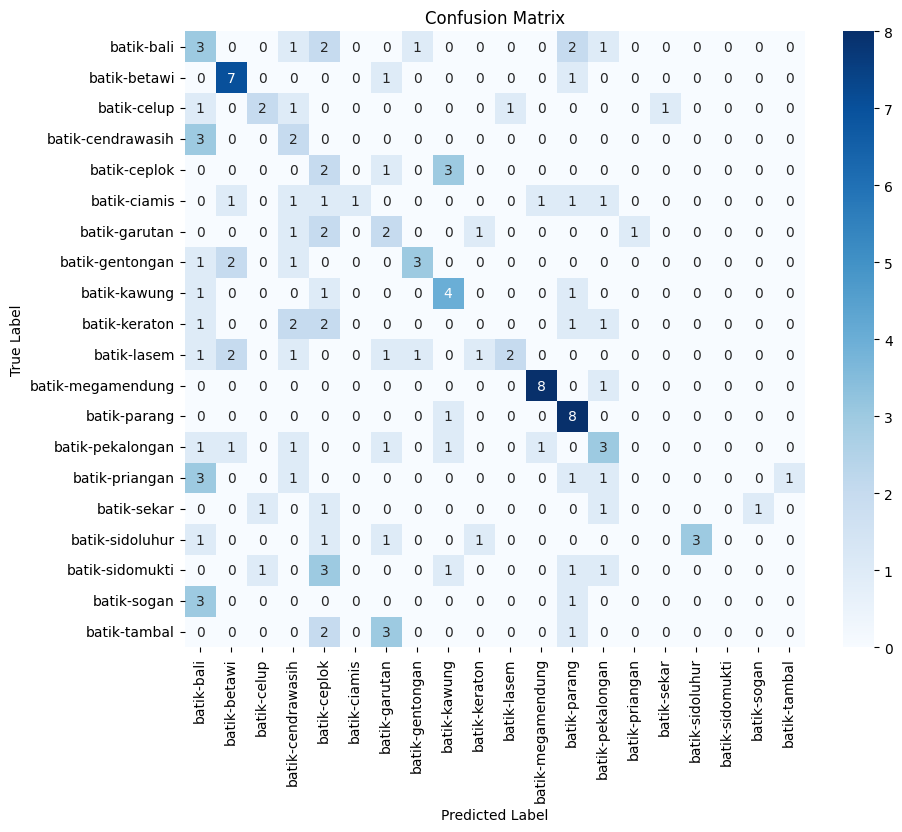

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [13]:
model.save("Densenet_20_model.h5")